In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# apply some styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

In [6]:
weather_df = pd.read_csv('cleaned_weather.csv')
# read the solar plant generation data
solar_df = pd.read_csv('plant_output.csv')
# drop unused columns
solar_df = solar_df.drop(['Plant', 'Real-time power(kW)', 'Daily feed-in energy(kWh)', 'Energy purchased today(kWh)'], axis=1)

# Both weather and solar df are date aligned
data_df = weather_df
data_df['output'] = solar_df['Daily yield(kWh)']
# Remove entries with known 0 output
data_df = data_df[~(data_df['output'] == 0)]
data_df.drop(data_df.columns[0], axis=1, inplace=True)

/var/folders/zh/nt4cvtjd1bl_ntm3_d6kztf40000gn/T/ipykernel_24692/720678684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.drop(data_df.columns[0], axis=1, inplace=True)


In [7]:
data_df.head()

,datetime,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,cloudcover,solarradiation,solarenergy,solartime,output
0,2025-01-01,29.0,16.1,22.0,15.8,70.6,0.0,0,0.0,3.2,212.9,18.5,662.33,11.7
1,2025-01-02,30.8,14.9,22.1,13.6,63.1,0.0,0,0.0,8.9,218.2,18.8,662.62,12.5
2,2025-01-03,29.3,12.9,21.0,10.4,56.5,0.0,0,0.0,30.0,222.0,19.2,662.92,12.7
3,2025-01-04,29.8,11.2,20.0,8.6,51.8,0.0,0,0.0,3.9,224.0,19.4,663.23,10.5
4,2025-01-05,30.1,12.2,20.7,10.2,54.5,0.0,0,0.0,20.6,217.9,18.9,663.58,11.1


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
scaler = StandardScaler()
numeric_cols = data_df.select_dtypes(include=[np.number]).columns
data_df = data_df[numeric_cols]
data_norm = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)
data_norm.head(5)

,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,cloudcover,solarradiation,solarenergy,solartime,output
0,-1.403946,-0.829721,-1.376138,0.242118,1.004365,-0.293308,-0.6003,-0.451987,-0.883851,-0.680943,-0.651917,-1.509529,-0.281256
1,-0.916350,-1.188969,-1.340224,-0.316047,0.483319,-0.293308,-0.6003,-0.451987,-0.686336,-0.583275,-0.588037,-1.502480,-0.042159
2,-1.322680,-1.787716,-1.735276,-1.127923,0.024799,-0.293308,-0.6003,-0.451987,0.044818,-0.513248,-0.502863,-1.495189,0.017616
3,-1.187236,-2.296651,-2.094413,-1.584603,-0.301724,-0.293308,-0.6003,-0.451987,-0.859595,-0.476393,-0.460277,-1.487654,-0.639903
4,-1.105970,-1.997277,-1.843017,-1.178665,-0.114147,-0.293308,-0.6003,-0.451987,-0.280909,-0.588803,-0.566744,-1.479148,-0.460580


In [37]:
# Split data 
X = data_norm.drop('output', axis=1)
y = data_norm['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
print( 'X ', X.shape)
print( 'y ', y.shape)
print( 'X_train ', X_train.shape)
print( 'y_train ', y_train.shape)

X  (151, 12)
y  (151,)
X_train  (120, 12)
y_train  (120,)


In [38]:
def predict_and_eval(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    tr_mse = mean_squared_error(y_train, y_train_pred)
    tr_r2 = r2_score(y_train, y_train_pred)

    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"Train Mean Squared Error: {tr_mse}")
    print(f"Train R-squared: {tr_r2}")

    print(f"Test Mean Squared Error: {mse}")
    print(f"Test R-squared: {r2}")

    metrics = {
        'train_mse' : tr_mse,
        'train_r2' : tr_r2,
        'test_mse' : mse,
        'test_r2' : r2
        }

    return metrics, y_train_pred, y_test_pred

In [39]:
dt_reg = DecisionTreeRegressor(random_state=0)
dt_reg.fit(X_train, y_train)

dt_metrics, dt_y_train_pred, dt_y_test_pred = predict_and_eval(dt_reg, X_train, y_train, X_test, y_test)

Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 1.2653249371266673
Test R-squared: -0.86717736294183


In [ ]:
# Tree details
print ('depth: ', dt_reg.get_depth())
print ('leaves: ',dt_reg.get_n_leaves())
print ('features: ',dt_reg.max_features_)

depth:  12
leaves:  113
features:  12


In [42]:
# It seems the the curren tree model have high bias(underfitting). Let's try adding more features using PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly  = poly.fit_transform(X)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [46]:
dt_poly_reg = DecisionTreeRegressor(random_state=0)
dt_poly_reg.fit(X_poly_train, y_poly_train)

dt_poly_metrics, dt_poly_y_train_pred, dt_poly_y_test_pred = predict_and_eval(dt_poly_reg, X_poly_train, y_poly_train, X_poly_test, y_poly_test)

Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.6484959587132004
Test R-squared: 0.4247738871620673


In [47]:
# Tree details
print ('depth: ', dt_poly_reg.get_depth())
print ('leaves: ',dt_poly_reg.get_n_leaves())
print ('features: ',dt_poly_reg.max_features_)

depth:  11
leaves:  104
features:  90


### Observations
1. Polynomial features significantly improved the R2 score 
2. At the same time, the training R2 score of 1 indicates overfitting

To address this following variations with max_features, max_leaf nodes are performed.

In [59]:
feature_cnts = [20, 40, 60, 80, 100, 120]
dt_f_metrics = []
for fcnt in feature_cnts:
    print('-- Decisions tree with max features : ', fcnt)
    dt_poly_reg_f = DecisionTreeRegressor(random_state=0, max_features=fcnt)
    dt_poly_reg_f.fit(X_poly_train, y_poly_train)

    dt_poly_metrics_f, dt_poly_y_train_pred_f, dt_poly_y_test_pred_f = predict_and_eval(dt_poly_reg_f, X_poly_train, y_poly_train, X_poly_test, y_poly_test)
    dt_poly_metrics_f['features'] = fcnt
    dt_f_metrics.append(dt_poly_metrics_f)

-- Decisions tree with max features :  20
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 1.4804817541404178
Test R-squared: -0.31321059617937363
-- Decisions tree with max features :  40
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.6340599649641862
Test R-squared: 0.4375788406203366
-- Decisions tree with max features :  60
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.5888214216788523
Test R-squared: 0.4777061398807805
-- Decisions tree with max features :  80
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.6101440471763984
Test R-squared: 0.4587926357707621
-- Decisions tree with max features :  100
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.6484959587132004
Test R-squared: 0.4247738871620673
-- Decisions tree with max features :  120
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.6484959587132004

In [60]:
f_metrics_df = pd.DataFrame(dt_f_metrics)
f_metrics_df.head()

,train_mse,train_r2,test_mse,test_r2,features
0,0.0,1.0,1.480482,-0.313211,20
1,0.0,1.0,0.634060,0.437579,40
2,0.0,1.0,0.588821,0.477706,60
3,0.0,1.0,0.610144,0.458793,80
4,0.0,1.0,0.648496,0.424774,100


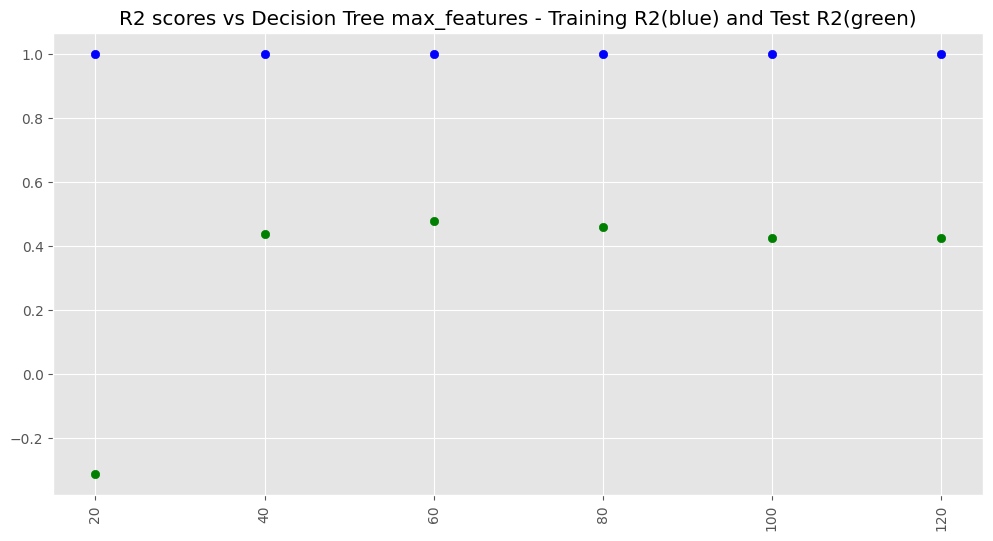

In [61]:
# Scatter plot of R2 scores for training and test datasets as alpha varies
plt.scatter(x=f_metrics_df['features'], y=f_metrics_df['train_r2'], c='blue')
plt.scatter(x=f_metrics_df['features'], y=f_metrics_df['test_r2'], c='green')
plt.xticks(rotation=90)
plt.title('R2 scores vs Decision Tree max_features - Training R2(blue) and Test R2(green)')
plt.show()

- In all variations training R2 score indicates overfitting
- The test R2 score however peaks around 0.47 (`max_features` = 60) before delicing with increasing number of features

Let's try other tuning another hyper parameters namely `max_depth`

In [63]:
depth_cnts = [4, 8, 12, 16, 20, 24, 28, 32]
dt_d_metrics = []
for fcnt in depth_cnts:
    print('-- Decisions tree with max depth : ', fcnt)
    dt_poly_reg_f = DecisionTreeRegressor(random_state=0, max_features=60, max_depth=fcnt)
    dt_poly_reg_f.fit(X_poly_train, y_poly_train)

    dt_poly_metrics_f, dt_poly_y_train_pred_f, dt_poly_y_test_pred_f = predict_and_eval(dt_poly_reg_f, X_poly_train, y_poly_train, X_poly_test, y_poly_test)
    dt_poly_metrics_f['max_depth'] = fcnt
    dt_d_metrics.append(dt_poly_metrics_f)

-- Decisions tree with max depth :  4
Train Mean Squared Error: 0.12874804985762398
Train R-squared: 0.8660424287381311
Test Mean Squared Error: 0.8782328805119833
Test R-squared: 0.22099362496291597
-- Decisions tree with max depth :  8
Train Mean Squared Error: 0.006988703755944185
Train R-squared: 0.9927285129176693
Test Mean Squared Error: 0.6979897091485975
Test R-squared: 0.380872152247301
-- Decisions tree with max depth :  12
Train Mean Squared Error: 1.9849891604322215e-05
Train R-squared: 0.999979346923918
Test Mean Squared Error: 0.6217162138221759
Test R-squared: 0.44852794198612855
-- Decisions tree with max depth :  16
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.5888214216788523
Test R-squared: 0.4777061398807805
-- Decisions tree with max depth :  20
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.5888214216788523
Test R-squared: 0.4777061398807805
-- Decisions tree with max depth :  24
Train Mean Squared Er

In [64]:
d_metrics_df = pd.DataFrame(dt_d_metrics)
d_metrics_df.head()

,train_mse,train_r2,test_mse,test_r2,max_depth
0,0.128748,0.866042,0.878233,0.220994,4
1,0.006989,0.992729,0.697990,0.380872,8
2,0.000020,0.999979,0.621716,0.448528,12
3,0.000000,1.000000,0.588821,0.477706,16
4,0.000000,1.000000,0.588821,0.477706,20


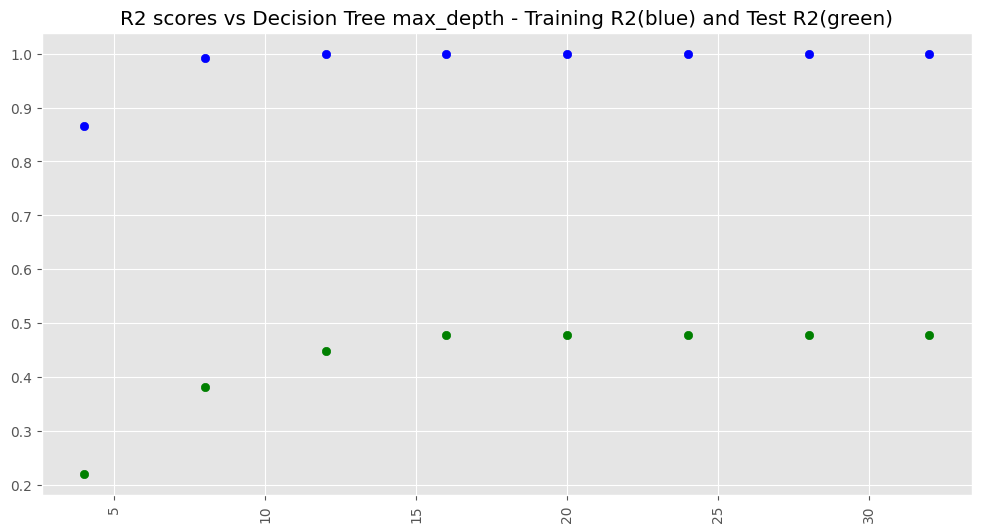

In [65]:
# Scatter plot of R2 scores for training and test datasets as alpha varies
plt.scatter(x=d_metrics_df['max_depth'], y=d_metrics_df['train_r2'], c='blue')
plt.scatter(x=d_metrics_df['max_depth'], y=d_metrics_df['test_r2'], c='green')
plt.xticks(rotation=90)
plt.title('R2 scores vs Decision Tree max_depth - Training R2(blue) and Test R2(green)')
plt.show()

- In the variatiions once `max_depth` reaches 8, training R2 score indicates overfitting
- The test R2 score however peaks around 0.47 (max_depth >= 14) and stagnates with increasing number of max_depth

Let's try varying number of leaf nodes

In [72]:
ln_cnts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
dt_ln_metrics = []
for fcnt in ln_cnts:
    print('-- Decisions tree with max leaf nodes : ', fcnt)
    dt_poly_reg_f = DecisionTreeRegressor(random_state=0, max_features=60, max_depth=16, max_leaf_nodes=fcnt)
    dt_poly_reg_f.fit(X_poly_train, y_poly_train)

    dt_poly_metrics_f, dt_poly_y_train_pred_f, dt_poly_y_test_pred_f = predict_and_eval(dt_poly_reg_f, X_poly_train, y_poly_train, X_poly_test, y_poly_test)
    dt_poly_metrics_f['max_ln'] = fcnt
    dt_ln_metrics.append(dt_poly_metrics_f)

-- Decisions tree with max leaf nodes :  5
Train Mean Squared Error: 0.3067269866232405
Train R-squared: 0.6808619453734743
Test Mean Squared Error: 0.47468411974210906
Test R-squared: 0.57894772148317
-- Decisions tree with max leaf nodes :  10
Train Mean Squared Error: 0.13046175841177282
Train R-squared: 0.8642593785403352
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189
-- Decisions tree with max leaf nodes :  15
Train Mean Squared Error: 0.07447361269484849
Train R-squared: 0.9225129678412117
Test Mean Squared Error: 0.5531640475791546
Test R-squared: 0.5093347914117428
-- Decisions tree with max leaf nodes :  20
Train Mean Squared Error: 0.04233080728179237
Train R-squared: 0.9559563648591657
Test Mean Squared Error: 0.5804001919032903
Test R-squared: 0.48517590311372916
-- Decisions tree with max leaf nodes :  25
Train Mean Squared Error: 0.02352739502728407
Train R-squared: 0.9755206179863787
Test Mean Squared Error: 0.6312545513006959
Test R-squa

In [73]:
ln_metrics_df = pd.DataFrame(dt_ln_metrics)
ln_metrics_df.head()

,train_mse,train_r2,test_mse,test_r2,max_ln
0,0.306727,0.680862,0.474684,0.578948,5
1,0.130462,0.864259,0.459310,0.592585,10
2,0.074474,0.922513,0.553164,0.509335,15
3,0.042331,0.955956,0.580400,0.485176,20
4,0.023527,0.975521,0.631255,0.440067,25


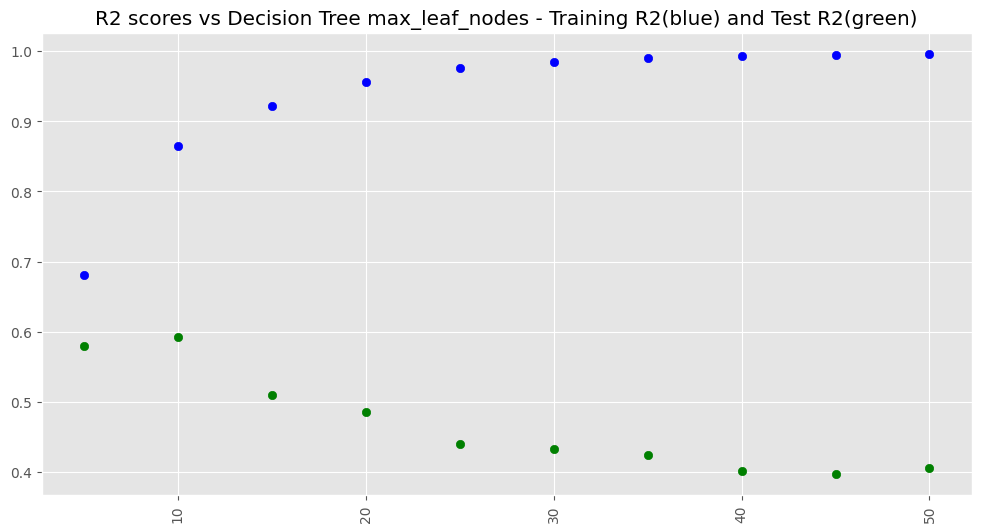

In [74]:
# Scatter plot of R2 scores for training and test datasets as alpha varies
plt.scatter(x=ln_metrics_df['max_ln'], y=ln_metrics_df['train_r2'], c='blue')
plt.scatter(x=ln_metrics_df['max_ln'], y=ln_metrics_df['test_r2'], c='green')
plt.xticks(rotation=90)
plt.title('R2 scores vs Decision Tree max_leaf_nodes - Training R2(blue) and Test R2(green)')
plt.show()

- In the variations, once `max_leaf_nodes` crosses 25, training R2 score indicates overfitting
- The model with `max_leaf_count` = 10 could be more generalized as it shows training R2 = 0.86 and testing R2 = 0.6
- The test R2 score however peaks at 0.6 (max_leaf_nodes = 10) and declines gradually towards 0.5


In [84]:
# min_samples_leaf
msl_cnts = [2, 4, 6, 8, 10, 12]
dt_msl_metrics = []
for fcnt in range(1, 10, 1):
    print('-- Decisions tree with min samples leaf nodes : ', fcnt)
    dt_poly_reg_f = DecisionTreeRegressor(random_state=0, max_features=60, max_depth=16, max_leaf_nodes=10, min_samples_leaf=fcnt)
    dt_poly_reg_f.fit(X_poly_train, y_poly_train)

    dt_poly_metrics_f, dt_poly_y_train_pred_f, dt_poly_y_test_pred_f = predict_and_eval(dt_poly_reg_f, X_poly_train, y_poly_train, X_poly_test, y_poly_test)
    dt_poly_metrics_f['min_sl'] = fcnt
    dt_msl_metrics.append(dt_poly_metrics_f)

-- Decisions tree with min samples leaf nodes :  1
Train Mean Squared Error: 0.13046175841177282
Train R-squared: 0.8642593785403352
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189
-- Decisions tree with min samples leaf nodes :  2
Train Mean Squared Error: 0.14412092371805604
Train R-squared: 0.8500475235886097
Test Mean Squared Error: 1.0391502136662585
Test R-squared: 0.07825742006465708
-- Decisions tree with min samples leaf nodes :  3
Train Mean Squared Error: 0.15819812048076526
Train R-squared: 0.8354007224091485
Test Mean Squared Error: 0.49657104387425377
Test R-squared: 0.559533675610788
-- Decisions tree with min samples leaf nodes :  4
Train Mean Squared Error: 0.16828551682684517
Train R-squared: 0.8249051606016413
Test Mean Squared Error: 0.5580032957693092
Test R-squared: 0.5050423021709398
-- Decisions tree with min samples leaf nodes :  5
Train Mean Squared Error: 0.1912190556906387
Train R-squared: 0.8010436639030057
Test Mean Squared 

In [85]:
msl_metrics_df = pd.DataFrame(dt_msl_metrics)
msl_metrics_df.head()

,train_mse,train_r2,test_mse,test_r2,min_sl
0,0.130462,0.864259,0.459310,0.592585,1
1,0.144121,0.850048,1.039150,0.078257,2
2,0.158198,0.835401,0.496571,0.559534,3
3,0.168286,0.824905,0.558003,0.505042,4
4,0.191219,0.801044,0.714853,0.365914,5


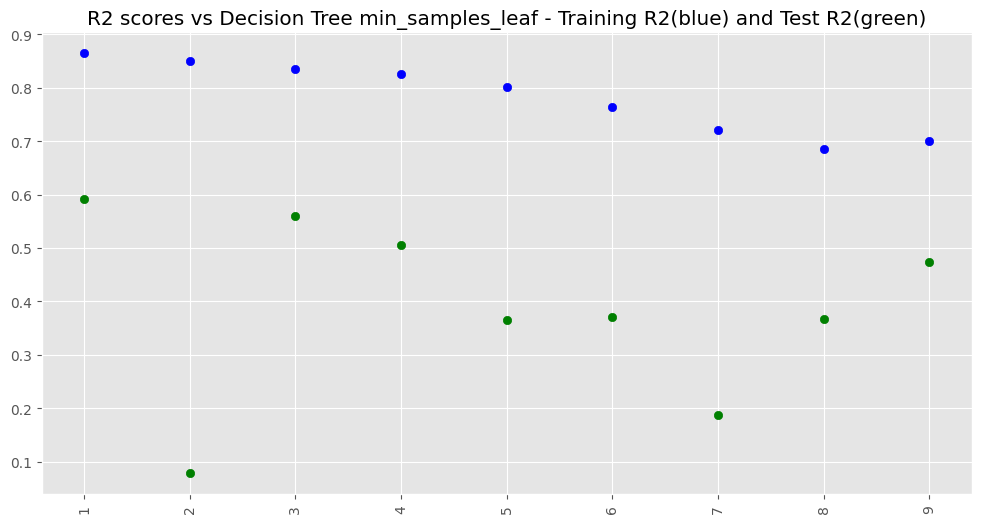

In [86]:
# Scatter plot of R2 scores for training and test datasets as alpha varies
plt.scatter(x=msl_metrics_df['min_sl'], y=msl_metrics_df['train_r2'], c='blue')
plt.scatter(x=msl_metrics_df['min_sl'], y=msl_metrics_df['test_r2'], c='green')
plt.xticks(rotation=90)
plt.title('R2 scores vs Decision Tree min_samples_leaf - Training R2(blue) and Test R2(green)')
plt.show()

- Any `max_leaf_nodes` count > 1 shows reduced R2 score for both training and test data. Hence changing the default value of 1 doesn't improve the accuracy.

In [87]:
# A final DT regressor test with optimal hyper parameters
dt_poly_reg_ = DecisionTreeRegressor(random_state=0, max_features=60, max_depth=16, max_leaf_nodes=10)
dt_poly_reg_.fit(X_poly_train, y_poly_train)

dt_poly_metrics_, dt_poly_y_train_pred, dt_poly_y_test_pred = predict_and_eval(dt_poly_reg_, X_poly_train, y_poly_train, X_poly_test, y_poly_test)

Train Mean Squared Error: 0.13046175841177282
Train R-squared: 0.8642593785403352
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189


In [88]:
# Tree details
print ('depth: ', dt_poly_reg_.get_depth())
print ('leaves: ',dt_poly_reg_.get_n_leaves())
print ('features: ',dt_poly_reg_.max_features_)

depth:  6
leaves:  10
features:  60
